In [2]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [3]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

# Quick EDA and preprocessing
- Fill nulls with modes in both datasets.
- Log fare
- Add dummy columns

In [4]:
train = pd.read_csv(path/'train.csv')
test = pd.read_csv(path/'test.csv')
ss = pd.read_csv(path/'gender_submission.csv')

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train.describe(include=np.number)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [8]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
train.fillna(train.mode().loc[0], inplace=True)
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

<AxesSubplot:>

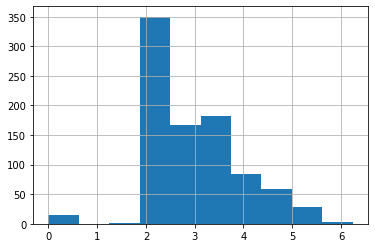

In [10]:
train.drop(columns=['PassengerId', 'Name', 'Cabin', 'Ticket'], inplace=True)
train.Fare = np.log(train.Fare + 1)
train.Fare.hist()

In [11]:
train = pd.get_dummies(train, columns=['Pclass', 'Sex', 'Embarked'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Age         891 non-null    float64
 2   SibSp       891 non-null    int64  
 3   Parch       891 non-null    int64  
 4   Fare        891 non-null    float64
 5   Pclass_1    891 non-null    uint8  
 6   Pclass_2    891 non-null    uint8  
 7   Pclass_3    891 non-null    uint8  
 8   Sex_female  891 non-null    uint8  
 9   Sex_male    891 non-null    uint8  
 10  Embarked_C  891 non-null    uint8  
 11  Embarked_Q  891 non-null    uint8  
 12  Embarked_S  891 non-null    uint8  
dtypes: float64(2), int64(3), uint8(8)
memory usage: 41.9 KB


In [12]:
train = train / train.max()
train.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.2750,0.125,0.0,0.338125,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.4750,0.125,0.0,0.685892,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.0,0.3250,0.000,0.0,0.350727,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.4375,0.125,0.0,0.639463,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.4375,0.000,0.0,0.352955,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [13]:
def process_ds(df):
    df.fillna(df.mode().loc[0], inplace=True)
    df.drop(columns=['PassengerId', 'Name', 'Cabin', 'Ticket'], inplace=True)
    df.Fare = np.log(df.Fare + 1)
    df.Fare.hist()
    df = pd.get_dummies(df, columns=['Pclass', 'Sex', 'Embarked'])
    df = df / df.max()

In [14]:
tr_dep = train.Survived
tr_indep = train.drop(columns=['Survived'])

In [15]:
from torch import tensor

t_dep = tensor(tr_dep.values)
t_indep = tensor(tr_indep.values)
t_indep.shape, t_dep.shape

(torch.Size([891, 12]), torch.Size([891]))

# Linear

## Initialize coefficients

In [16]:
torch.manual_seed(442)

def init_coeffs():
    return (torch.rand(t_indep.shape[1]) - 0.5).requires_grad_()
    
coeffs = init_coeffs()

## Make predictions

In [17]:
def calc_preds(t_indep, coeffs):
    return (t_indep*coeffs).sum(axis=1)

preds = calc_preds(t_indep, coeffs)
preds.shape, preds[:10]

(torch.Size([891]),
 tensor([ 0.9436, -0.7465,  0.9339,  0.0830,  0.8477,  0.7575, -0.0771,  1.0984,  0.9973, -0.6285], dtype=torch.float64,
        grad_fn=<SliceBackward>))

## Calculate loss

In [18]:
def calc_loss(preds, t_dep):
    return torch.abs(preds - t_dep).mean()

loss = calc_loss(preds, t_dep)
loss

tensor(0.7086, dtype=torch.float64, grad_fn=<MeanBackward0>)

## Calculate accuracy

In [19]:
def calc_accuracy(preds, t_dep):
    return ((preds > 0.5).int() == t_dep).float().mean()

accuracy = calc_accuracy(preds, t_dep)
accuracy

tensor(0.3513)

## Do one GD

In [20]:
loss = calc_loss(calc_preds(t_indep, coeffs), t_dep)
loss

tensor(0.7086, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [21]:
loss.backward()
coeffs.grad

tensor([-0.0081,  0.0194,  0.0067, -0.0253, -0.1773, -0.0516,  0.3199, -0.1526,  0.2435, -0.0988,  0.0146,  0.1751])

## Learn

In [22]:
with torch.no_grad():
    coeffs.sub_(coeffs.grad*0.1)
    coeffs.grad.zero_()
    loss = calc_loss(calc_preds(t_indep, coeffs), t_dep)
    print(f'{loss:0.2f}')

0.68


## Validation set

In [23]:
from sklearn.model_selection import train_test_split

indices = np.arange(len(train))
in_train, in_val = train_test_split(indices, shuffle=True, test_size=0.25, random_state=42)

In [24]:
train_indep, val_indep = t_indep[in_train], t_indep[in_val]
train_dep, val_dep = t_dep[in_train], t_dep[in_val]

## Training loop & epochs

In [25]:
def train(epochs=20, lr=0.3):
    coeffs = init_coeffs()
    for _ in range(0, epochs):
        preds = calc_preds(train_indep, coeffs)
        loss = calc_loss(preds, train_dep)
        loss.backward()
        with torch.no_grad(): 
            coeffs.sub_(coeffs.grad*lr)
            accuracy = calc_accuracy(calc_preds(val_indep, coeffs), val_dep)
            print(f'Epoch {_+1} loss: {loss:0.2f}, accuracy: {accuracy:0.2f}')

train()

Epoch 1 loss: 0.59, accuracy: 0.64
Epoch 2 loss: 0.47, accuracy: 0.43
Epoch 3 loss: 0.53, accuracy: 0.45
Epoch 4 loss: 0.52, accuracy: 0.74
Epoch 5 loss: 0.40, accuracy: 0.75
Epoch 6 loss: 0.49, accuracy: 0.79
Epoch 7 loss: 0.65, accuracy: 0.75
Epoch 8 loss: 0.57, accuracy: 0.70
Epoch 9 loss: 0.47, accuracy: 0.44
Epoch 10 loss: 0.69, accuracy: 0.44
Epoch 11 loss: 0.74, accuracy: 0.48
Epoch 12 loss: 0.50, accuracy: 0.61
Epoch 13 loss: 0.43, accuracy: 0.60
Epoch 14 loss: 0.65, accuracy: 0.60
Epoch 15 loss: 0.49, accuracy: 0.28
Epoch 16 loss: 0.63, accuracy: 0.28
Epoch 17 loss: 0.77, accuracy: 0.40
Epoch 18 loss: 0.77, accuracy: 0.47
Epoch 19 loss: 0.57, accuracy: 0.72
Epoch 20 loss: 0.33, accuracy: 0.76


## Sigmoid

In [26]:
preds[:20]

tensor([ 0.9436, -0.7465,  0.9339,  0.0830,  0.8477,  0.7575, -0.0771,  1.0984,  0.9973, -0.6285,  1.0939, -0.0429,  0.9345,  0.9965,
         1.0037, -0.0595,  0.9522,  0.0932,  0.8949,  0.1468], dtype=torch.float64, grad_fn=<SliceBackward>)

In [27]:
def calc_preds(indep, coeffs):
    return torch.sigmoid((indep*coeffs).sum(axis=1))

In [28]:
train()

Epoch 1 loss: 0.51, accuracy: 0.34
Epoch 2 loss: 0.51, accuracy: 0.62
Epoch 3 loss: 0.50, accuracy: 0.67
Epoch 4 loss: 0.48, accuracy: 0.69
Epoch 5 loss: 0.45, accuracy: 0.69
Epoch 6 loss: 0.42, accuracy: 0.70
Epoch 7 loss: 0.39, accuracy: 0.70
Epoch 8 loss: 0.37, accuracy: 0.71
Epoch 9 loss: 0.34, accuracy: 0.73
Epoch 10 loss: 0.33, accuracy: 0.73
Epoch 11 loss: 0.31, accuracy: 0.73
Epoch 12 loss: 0.30, accuracy: 0.73
Epoch 13 loss: 0.29, accuracy: 0.73
Epoch 14 loss: 0.29, accuracy: 0.73
Epoch 15 loss: 0.28, accuracy: 0.73
Epoch 16 loss: 0.28, accuracy: 0.73
Epoch 17 loss: 0.27, accuracy: 0.73
Epoch 18 loss: 0.26, accuracy: 0.75
Epoch 19 loss: 0.26, accuracy: 0.78
Epoch 20 loss: 0.25, accuracy: 0.78


In [29]:
calc_preds(val_indep, coeffs)[:10]

tensor([0.5251, 0.5061, 0.7031, 0.5605, 0.5502, 0.5303, 0.6850, 0.7094, 0.6949, 0.5696], dtype=torch.float64, grad_fn=<SliceBackward>)

## Matrix

In [30]:
def init_coeffs():
    return (torch.rand(t_indep.shape[1], 1) - 0.5).requires_grad_()

coeffs = init_coeffs()
coeffs

tensor([[ 0.4354],
        [-0.3408],
        [-0.4552],
        [ 0.1447],
        [-0.4648],
        [-0.3039],
        [-0.1297],
        [-0.0850],
        [ 0.4682],
        [ 0.3973],
        [-0.4849],
        [ 0.2098]], requires_grad=True)

In [31]:
def calc_preds(indep, coeffs):
    return torch.sigmoid(indep.float()@coeffs)

preds = calc_preds(val_indep, init_coeffs())
preds[:10]

tensor([[0.5434],
        [0.2646],
        [0.4233],
        [0.2893],
        [0.5466],
        [0.2760],
        [0.6232],
        [0.4551],
        [0.6303],
        [0.2859]], grad_fn=<SliceBackward>)

In [32]:
train_dep = train_dep[:, None]
val_dep = val_dep[:, None]

In [33]:
train()

Epoch 1 loss: 0.44, accuracy: 0.73
Epoch 2 loss: 0.43, accuracy: 0.74
Epoch 3 loss: 0.42, accuracy: 0.75
Epoch 4 loss: 0.41, accuracy: 0.75
Epoch 5 loss: 0.39, accuracy: 0.75
Epoch 6 loss: 0.37, accuracy: 0.75
Epoch 7 loss: 0.35, accuracy: 0.75
Epoch 8 loss: 0.34, accuracy: 0.76
Epoch 9 loss: 0.32, accuracy: 0.76
Epoch 10 loss: 0.31, accuracy: 0.77
Epoch 11 loss: 0.30, accuracy: 0.78
Epoch 12 loss: 0.29, accuracy: 0.78
Epoch 13 loss: 0.28, accuracy: 0.78
Epoch 14 loss: 0.27, accuracy: 0.78
Epoch 15 loss: 0.26, accuracy: 0.79
Epoch 16 loss: 0.26, accuracy: 0.78
Epoch 17 loss: 0.25, accuracy: 0.79
Epoch 18 loss: 0.24, accuracy: 0.78
Epoch 19 loss: 0.23, accuracy: 0.78
Epoch 20 loss: 0.23, accuracy: 0.78


# Neural Network

In [34]:
def init_coeffs(hidden=20):
    layer1_coeffs = (torch.rand(train_indep.shape[1], hidden)-0.5).requires_grad_()
    layer2_coeffs = (torch.rand(hidden, 1)-0.5).requires_grad_()
    return layer1_coeffs, layer2_coeffs

In [35]:
def calc_preds(indep, coeffs):
    layer1, layer2 = coeffs
    layer1_res = indep.float()@layer1
    layer2_res = layer1_res@layer2
    return torch.sigmoid(layer2_res)

In [36]:
def update_coeffs(coeffs, lr):
    layer1, layer2 = coeffs
    layer1.sub_(layer1.grad*lr)
    layer2.sub_(layer2.grad*lr)
    layer1.grad.zero_()
    layer2.grad.zero_()
    

def train(epochs=20, lr=0.3):
    coeffs = init_coeffs()
    for _ in range(0, epochs):
        preds = calc_preds(train_indep, coeffs)
        loss = calc_loss(preds, train_dep)
        loss.backward()
        with torch.no_grad(): 
            update_coeffs(coeffs, lr)
            accuracy = calc_accuracy(calc_preds(val_indep, coeffs), val_dep)
            print(f'Epoch {_+1} loss: {loss:0.2f}, accuracy: {accuracy:0.2f}')

train(25, 5)

Epoch 1 loss: 0.51, accuracy: 0.67
Epoch 2 loss: 0.33, accuracy: 0.78
Epoch 3 loss: 0.28, accuracy: 0.81
Epoch 4 loss: 0.24, accuracy: 0.80
Epoch 5 loss: 0.23, accuracy: 0.79
Epoch 6 loss: 0.22, accuracy: 0.81
Epoch 7 loss: 0.21, accuracy: 0.82
Epoch 8 loss: 0.21, accuracy: 0.81
Epoch 9 loss: 0.21, accuracy: 0.81
Epoch 10 loss: 0.21, accuracy: 0.81
Epoch 11 loss: 0.20, accuracy: 0.81
Epoch 12 loss: 0.20, accuracy: 0.81
Epoch 13 loss: 0.20, accuracy: 0.81
Epoch 14 loss: 0.20, accuracy: 0.81
Epoch 15 loss: 0.20, accuracy: 0.81
Epoch 16 loss: 0.20, accuracy: 0.81
Epoch 17 loss: 0.20, accuracy: 0.81
Epoch 18 loss: 0.20, accuracy: 0.81
Epoch 19 loss: 0.20, accuracy: 0.81
Epoch 20 loss: 0.20, accuracy: 0.81
Epoch 21 loss: 0.19, accuracy: 0.81
Epoch 22 loss: 0.19, accuracy: 0.81
Epoch 23 loss: 0.19, accuracy: 0.81
Epoch 24 loss: 0.19, accuracy: 0.81
Epoch 25 loss: 0.19, accuracy: 0.81


## Deep Learning

In [37]:
def init_coeffs(layers=[12,12]):
    sizes = [train_indep.shape[1]] + layers + [1]
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.5).requires_grad_() for i in range(len(sizes)-1)]
    return layers

coeffs = init_coeffs()
for l in coeffs: print(l.shape)

torch.Size([12, 12])
torch.Size([12, 12])
torch.Size([12, 1])


In [38]:
def calc_preds(indep, coeffs):
    res = indep.float()
    for l in coeffs: res = res@l
    return torch.sigmoid(res)

preds = calc_preds(train_indep, coeffs)
preds.shape, preds[:10]

(torch.Size([668, 1]),
 tensor([[0.5127],
         [0.5546],
         [0.6351],
         [0.5527],
         [0.4876],
         [0.6612],
         [0.5847],
         [0.6406],
         [0.5679],
         [0.5075]], grad_fn=<SliceBackward>))

In [39]:
def update_coeffs(coeffs, lr):
    for l in coeffs:
        l.sub_(l.grad*lr)
        l.grad.zero_()

In [40]:
train(25, 1)

Epoch 1 loss: 0.57, accuracy: 0.49
Epoch 2 loss: 0.50, accuracy: 0.61
Epoch 3 loss: 0.44, accuracy: 0.60
Epoch 4 loss: 0.40, accuracy: 0.62
Epoch 5 loss: 0.37, accuracy: 0.67
Epoch 6 loss: 0.36, accuracy: 0.67
Epoch 7 loss: 0.35, accuracy: 0.67
Epoch 8 loss: 0.34, accuracy: 0.68
Epoch 9 loss: 0.33, accuracy: 0.68
Epoch 10 loss: 0.32, accuracy: 0.69
Epoch 11 loss: 0.30, accuracy: 0.74
Epoch 12 loss: 0.29, accuracy: 0.78
Epoch 13 loss: 0.27, accuracy: 0.78
Epoch 14 loss: 0.26, accuracy: 0.81
Epoch 15 loss: 0.24, accuracy: 0.81
Epoch 16 loss: 0.24, accuracy: 0.81
Epoch 17 loss: 0.23, accuracy: 0.81
Epoch 18 loss: 0.22, accuracy: 0.81
Epoch 19 loss: 0.22, accuracy: 0.81
Epoch 20 loss: 0.22, accuracy: 0.81
Epoch 21 loss: 0.22, accuracy: 0.81
Epoch 22 loss: 0.21, accuracy: 0.81
Epoch 23 loss: 0.21, accuracy: 0.81
Epoch 24 loss: 0.21, accuracy: 0.81
Epoch 25 loss: 0.21, accuracy: 0.81


## Hyper params testing

In [41]:
def train(epochs=20, lr=0.3, hidden=[12,12]):
    artifacts = []
    coeffs = init_coeffs(hidden)
    for _ in range(0, epochs):
        preds = calc_preds(train_indep, coeffs)
        loss = calc_loss(preds, train_dep)
        loss.backward()
        with torch.no_grad(): 
            update_coeffs(coeffs, lr)
            accuracy = calc_accuracy(calc_preds(val_indep, coeffs), val_dep)
            artifacts.append({ 'Epoch': _+1, 'Loss': loss, 'Accuracy': accuracy })
    return artifacts

In [42]:
runs = []

for i in range(10):
    hidden = [12 for _ in range(i+1)]
    results = train(100, 1, hidden)
    runs = runs + [
        {**{'Run': i+1, 'No_Hidden': len(hidden)}, **r}
        for r in results
    ]

runs_df = pd.DataFrame.from_records(runs)
runs_df['Loss'] = runs_df.Loss.astype(float)
runs_df.Accuracy = runs_df.Accuracy.astype(float)
runs_df.head()

,Run,No_Hidden,Epoch,Loss,Accuracy
0,1,1,1,0.463165,0.780269
1,1,1,2,0.426732,0.784753
2,1,1,3,0.391965,0.784753
3,1,1,4,0.361364,0.784753
4,1,1,5,0.336233,0.784753


(0.0, 20.0)

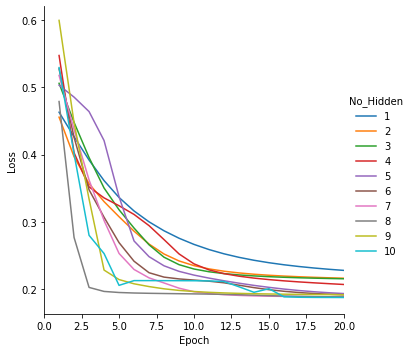

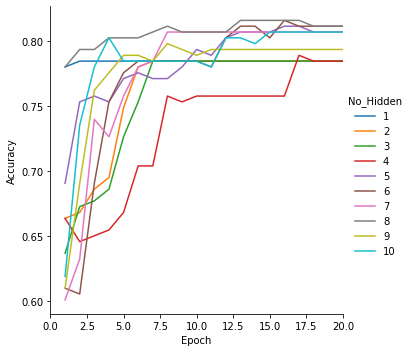

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

palette = sns.color_palette()

sns.relplot(data=runs_df, x='Epoch', y='Loss', hue='No_Hidden', kind='line', palette=palette)
plt.xlim(0,20)
sns.relplot(data=runs_df, x='Epoch', y='Accuracy', hue='No_Hidden', kind='line', palette=palette)
plt.xlim(0,20)

In [44]:
runs_df.groupby('No_Hidden')[['Loss', 'Accuracy']].describe()

Loss                                                                       Accuracy                                          \
           count      mean       std       min       25%       50%       75%       max    count      mean       std       min       25%   
No_Hidden                                                                                                                                 
1          100.0  0.223729  0.046364  0.196533  0.200834  0.208818  0.221221  0.463165    100.0  0.796682  0.011025  0.780269  0.784753   
2          100.0  0.210903  0.041863  0.189379  0.190982  0.196178  0.213036  0.455781    100.0  0.795291  0.026681  0.663677  0.784753   
3          100.0  0.211097  0.049948  0.187878  0.188671  0.193289  0.213508  0.506170    100.0  0.793812  0.029215  0.636771  0.784753   
4          100.0  0.206314  0.051085  0.187384  0.187559  0.188159  0.197780  0.547592    100.0  0.791614  0.037151  0.645740  0.807175   
5          100.0  0.204671  0.057834  0.187268  0.187354  0.187604  0.189694  0.503383    100.0  0.802511  0.016136  0.690583  0.807175   
6          100.0  0.199859  0.046303  0.186956  0.187185  0.187387  0.188805  0.527641    100.0  0.803632  0.031934  0.605381  0.811659   
7          100.0  0.198057  0.046245  0.187078  0.187199  0.187286  0.187707  0.517908    100.0  0.800897  0.029110  0.600897  0.807175   
8          100.0  0.191067  0.030568  0.185121  0.185480  0.186284  0.187532  0.479076    100.0  0.808296  0.005534  0.780269  0.802691   
9          100.0  0.198835  0.050266  0.186462  0.188354  0.189487  0.191346  0.599881    100.0  0.789955  0.021734  0.609865  0.789238   
10         100.0  0.195249  0.042036  0.183861  0.185063  0.185478  0.186906  0.529614    100.0  0.802870  0.021225  0.618834  0.802691   

                                         
                50%       75%       max  
No_Hidden                                
1          0.800448  0.807175  0.811659  
2          0.807175  0.807175  0.811659  
3          0.807175  0.807175  0.811659  
4          0.807175  0.807175  0.811659  
5          0.807175  0.807175  0.811659  
6          0.811659  0.811659  0.816144  
7          0.807175  0.807175  0.807175  
8          0.811659  0.811659  0.816144  
9          0.793722  0.793722  0.811659  
10         0.807175  0.807175  0.816144

## Activation functions

In [48]:
def calc_preds(indep, coeffs, activation_fn, **kwargs):
    res = indep.float()
    for i, l in enumerate(coeffs): 
        res = res@l
        if i != len(coeffs) - 1: res = activation_fn(res, **kwargs)
    return torch.sigmoid(res)

import torch.nn.functional as F

preds = calc_preds(train_indep, coeffs, F.relu)
preds.shape, preds[:10]

(torch.Size([668, 1]),
 tensor([[0.5117],
         [0.5497],
         [0.5891],
         [0.5485],
         [0.4901],
         [0.6049],
         [0.5601],
         [0.6035],
         [0.5033],
         [0.4939]], grad_fn=<SliceBackward>))

In [52]:
def train(epochs=20, lr=0.3, hidden=[12,12], activation_fn=F.relu, **kwargs):
    artifacts = []
    coeffs = init_coeffs(hidden)
    for _ in range(0, epochs):
        preds = calc_preds(train_indep, coeffs, activation_fn, **kwargs)
        loss = calc_loss(preds, train_dep)
        loss.backward()
        with torch.no_grad(): 
            update_coeffs(coeffs, lr)
            accuracy = calc_accuracy(calc_preds(val_indep, coeffs, activation_fn, **kwargs), val_dep)
            artifacts.append({ 'Epoch': _+1, 'Loss': loss, 'Accuracy': accuracy })
    return artifacts

Loss                                                                       Accuracy                                          \
           count      mean       std       min       25%       50%       75%       max    count      mean       std       min       25%   
No_Hidden                                                                                                                                 
1          100.0  0.230889  0.058793  0.195605  0.199067  0.205977  0.228940  0.483433    100.0  0.796009  0.035775  0.632287  0.807175   
2          100.0  0.225420  0.070066  0.189560  0.191274  0.196591  0.219301  0.537784    100.0  0.785426  0.064879  0.331839  0.784753   
3          100.0  0.201489  0.039412  0.187925  0.188340  0.189355  0.193802  0.448914    100.0  0.805336  0.012426  0.704036  0.807175   
4          100.0  0.208358  0.058065  0.187587  0.187841  0.188530  0.192869  0.490185    100.0  0.798206  0.033811  0.623318  0.807175   
5          100.0  0.199271  0.044512  0.186263  0.187274  0.187818  0.189500  0.485632    100.0  0.806771  0.010319  0.739910  0.807175   
6          100.0  0.200035  0.047399  0.187143  0.187526  0.187872  0.189374  0.496020    100.0  0.803408  0.021060  0.654709  0.807175   
7          100.0  0.208626  0.066414  0.187365  0.187488  0.187801  0.189482  0.498788    100.0  0.799955  0.027840  0.654709  0.807175   
8          100.0  0.201437  0.052674  0.187337  0.187436  0.187671  0.188711  0.493467    100.0  0.806413  0.003880  0.780269  0.807175   
9          100.0  0.230318  0.073449  0.201485  0.202362  0.202572  0.204355  0.517016    100.0  0.760538  0.054386  0.600897  0.765695   
10         100.0  0.212243  0.080870  0.184362  0.184515  0.187204  0.188296  0.521430    100.0  0.793901  0.052276  0.367713  0.802691   

                                         
                50%       75%       max  
No_Hidden                                
1          0.807175  0.807175  0.807175  
2          0.807175  0.807175  0.820628  
3          0.807175  0.807175  0.811659  
4          0.807175  0.807175  0.811659  
5          0.807175  0.811659  0.820628  
6          0.807175  0.807175  0.807175  
7          0.807175  0.807175  0.811659  
8          0.807175  0.807175  0.811659  
9          0.784753  0.784753  0.784753  
10         0.802691  0.807175  0.816144

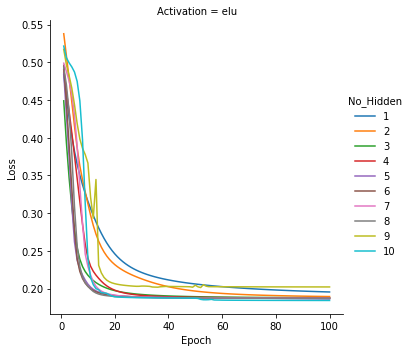

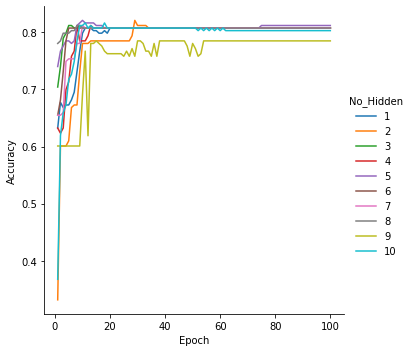

In [77]:
def test_hyper_params(activation_fn, **kwargs):
    runs = []

    for i in range(10):
        hidden = [12 for _ in range(i+1)]
        results = train(100, 1, hidden, activation_fn, **kwargs)
        runs = runs + [
            {**{'Run': i+1, 'No_Hidden': len(hidden)}, 'Activation': activation_fn.__name__, **r}
            for r in results
        ]

    runs_df = pd.DataFrame.from_records(runs)
    runs_df['Loss'] = runs_df.Loss.astype(float)
    runs_df.Accuracy = runs_df.Accuracy.astype(float)
    
    sns.relplot(data=runs_df, x='Epoch', y='Loss', hue='No_Hidden', kind='line', palette=palette, col='Activation')
#     plt.xlim(0,40)
    sns.relplot(data=runs_df, x='Epoch', y='Accuracy', hue='No_Hidden', kind='line', palette=palette)
#     plt.xlim(0,40)
    
    return runs_df

runs_df = test_hyper_params(F.elu, alpha=1.0)
runs_df.groupby('No_Hidden')[['Loss', 'Accuracy']].describe()